# Asset Management & Sustainable Finance
- Sarahnour Ghaith
- Thomas Roiseux

In [1]:
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import norm

from typing import Dict, Callable

import warnings

warnings.filterwarnings("ignore")

## Exercise 1 - Portfolio optimization and risk budgeting

In [2]:
corr_mat = np.array(
    [
        [1, 0.5, 0.3, 0.6, 0.4],
        [0.5, 1, 0.3, 0.6, 0.3],
        [0.3, 0.3, 1, 0.6, 0.7],
        [0.6, 0.6, 0.6, 1, 0.3],
        [0.4, 0.3, 0.7, 0.3, 1],
    ],
    dtype=np.float64,
)

r = 0.02  # risk free rate

mu = np.array([0.05, 0.05, 0.06, 0.04, 0.07], dtype=np.float64).T
sigma = np.array([0.2, 0.22, 0.25, 0.18, 0.45], dtype=np.float64).T

### Question 1.a

In [3]:
cov_mat = np.zeros_like(corr_mat)  # Covariance matrix

for i in range(len(cov_mat)):
    for j in range(i, len(cov_mat)):
        cov_mat[i, j] = corr_mat[i, j] * sigma[i] * sigma[j]
        cov_mat[j, i] = cov_mat[i, j]


print(cov_mat)

[[0.04    0.022   0.015   0.0216  0.036  ]
 [0.022   0.0484  0.0165  0.02376 0.0297 ]
 [0.015   0.0165  0.0625  0.027   0.07875]
 [0.0216  0.02376 0.027   0.0324  0.0243 ]
 [0.036   0.0297  0.07875 0.0243  0.2025 ]]


### Question 1.b

In [4]:
sr = (mu - r) / sigma  # Sharpe ratio

for k in range(len(mu)):
    print("Sharpe ratio for asset", k + 1, ":", sr[k])

Sharpe ratio for asset 1 : 0.15
Sharpe ratio for asset 2 : 0.13636363636363638
Sharpe ratio for asset 3 : 0.15999999999999998
Sharpe ratio for asset 4 : 0.11111111111111112
Sharpe ratio for asset 5 : 0.11111111111111112


### Question 2.b

In [5]:
def solve_qp_problem(gamma: float) -> np.ndarray:
    """Solver for the quadratic programming problem

    Args:
        gamma (float): gamma parameter

    Returns:
        np.ndarray: optimal portfolio weights
    """
    x = cp.Variable(len(mu), "x")  # Portfolio weights

    objective = cp.Minimize(
        0.5 * cp.quad_form(x, cov_mat) - gamma * cp.matmul(mu - r, x)
    )
    constraints = [cp.sum(x) == 1, -10 <= x, x <= 10]
    problem = cp.Problem(objective, constraints)

    problem.solve()

    return x.value

In [6]:
optimal_x: Dict[float, np.ndarray] = {}
gammas = [0, 0.1, 0.2, 0.5, 1]

for gamma in gammas:
    sol = solve_qp_problem(gamma)
    print("Optimal portfolio for gamma =", gamma, ":", sol)
    optimal_x[gamma] = sol

Optimal portfolio for gamma = 0 : [ 0.4232086   0.22380017  0.35945672  0.13351214 -0.13997763]
Optimal portfolio for gamma = 0.1 : [ 0.4619031   0.25313103  0.43093838  0.00774967 -0.15372218]
Optimal portfolio for gamma = 0.2 : [ 0.50059759  0.28246189  0.50242003 -0.1180128  -0.16746672]
Optimal portfolio for gamma = 0.5 : [ 0.61668108  0.37045447  0.716865   -0.49530021 -0.20870035]
Optimal portfolio for gamma = 1 : [ 0.81015355  0.51710878  1.07427329 -1.12411255 -0.27742307]


In [7]:
for gamma, sol in optimal_x.items():
    print("Gamma:", gamma)
    expected_return = np.dot(sol.T, mu)
    volatility = sol.T.dot(cov_mat).dot(sol)
    sharpe_ratio = (expected_return - r) / volatility
    print("  Expected return:", expected_return)
    print("  Volatility:", volatility)
    print("  Sharpe ratio:", sharpe_ratio)

Gamma: 0
  Expected return: 0.049459893213341655
  Volatility: 0.025088466131177472
  Sharpe ratio: 1.1742405079412888
Gamma: 0.1
  Expected return: 0.05115744358160653
  Volatility: 0.025258221168003973
  Sharpe ratio: 1.2335565269764697
Gamma: 0.2
  Expected return: 0.05285499394987142
  Volatility: 0.025767486278483423
  Sharpe ratio: 1.2750562315155383
Gamma: 0.5
  Expected return: 0.05794764505466612
  Volatility: 0.029332342051839707
  Sharpe ratio: 1.293713437120036
Gamma: 1
  Expected return: 0.0664353968959906
  Volatility: 0.042063969813826395
  Sharpe ratio: 1.1039233125525711


### Question 2.c

In [8]:
precise_gammas = np.linspace(-10, 10, 500)

solutions = [solve_qp_problem(gamma) for gamma in precise_gammas]
returns = np.array([np.dot(sol.T, mu) * 100 for sol in solutions])
volatilities = np.array([sol.T.dot(cov_mat).dot(sol) * 100 for sol in solutions])

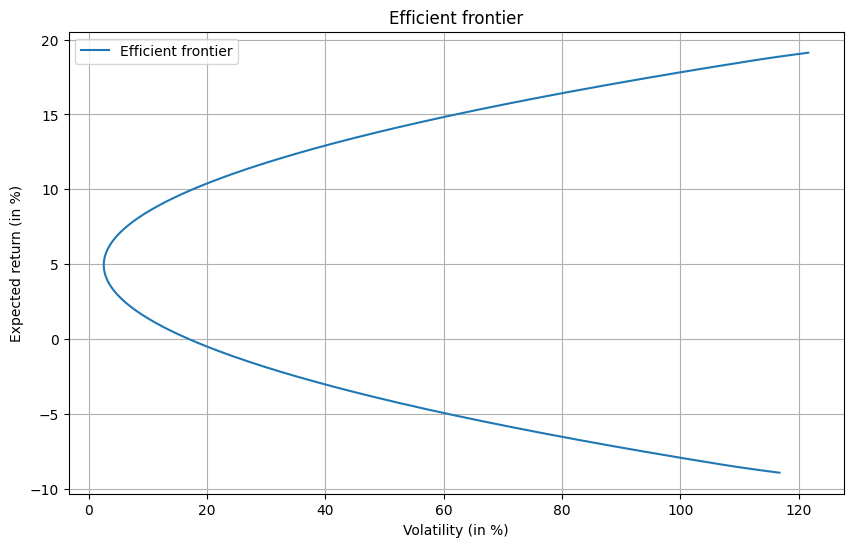

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(
    volatilities,
    returns,
    label="Efficient frontier",
)
plt.legend()
plt.grid(visible=True)
plt.xlabel("Volatility (in %)")
plt.ylabel("Expected return (in %)")
plt.title("Efficient frontier")
plt.show()

### Question 2.d

In [10]:
def bisection_algorithm(
    f: Callable[[float], float],
    a: float,
    b: float,
    target: float,
    /,
    tol: float = 10**-5,
    *,
    max_iter: int = 100,
) -> float:
    """Bisection algorithm

    Args:
        f (function): function to find the root of
        a (float): left bound
        b (float): right bound
        target (float): target value
        tol (float, optional): tolerance. Defaults to 10**-5.
        max_iter (int, optional): maximum number of iterations. Defaults to 100.

    Returns:
        float: root of the function
    """
    if b - a < 0:
        a, b = b, a

    gamma_bar = (a + b) / 2

    if b - a < tol or max_iter == 0:
        return gamma_bar

    f_bar = f(gamma_bar)

    if f_bar < target:
        a = gamma_bar
    else:
        b = gamma_bar

    return bisection_algorithm(f, a, b, target, tol=tol, max_iter=max_iter - 1)

In [11]:
targets = (16, 20)


def volatilities_function(gamma: float) -> float:
    sol = solve_qp_problem(gamma)
    return sol.T.dot(cov_mat).dot(sol) * 100


for target in targets:
    gamma = bisection_algorithm(
        volatilities_function,
        0,
        100,
        target,
    )
    print("Gamma for target volatility of", target, ":", gamma)
    print("  Expected return:", np.dot(solve_qp_problem(gamma).T, mu) * 100)
    print("  Volatility:", volatilities_function(gamma))
    print(
        "  Sharpe ratio:",
        (np.dot(solve_qp_problem(gamma).T, mu) - r) / volatilities_function(gamma),
    )

Gamma for target volatility of 16 : 2.8191179037094116
  Expected return: 9.731583956958229
  Volatility: 16.000002130301258
  Sharpe ratio: 0.004832239329716047
Gamma for target volatility of 20 : 3.209945559501648
  Expected return: 10.39503358797646
  Volatility: 19.99998206035408
  Sharpe ratio: 0.004197520559089858


### Question 2.e

In [12]:
sharpe_ratios = (returns - r * 100) / volatilities  # Converting r into %

i = np.argmax(sharpe_ratios)
tp = solve_qp_problem(precise_gammas[i])
print("Optimal portfolio for maximum Sharpe ratio:", tp)
print("Maximum Sharpe ratio:", sharpe_ratios[i])
print("Expected return (in %):", returns[i])
print("Volatility (in %):", volatilities[i])

Optimal portfolio for maximum Sharpe ratio: [ 0.57054235  0.3354808   0.63163137 -0.34534295 -0.19231157]
Maximum Sharpe ratio: 1.3039593883372305
Expected return (in %): 5.59235118500216
Volatility (in %): 2.7549563407668836


### Question 2.f
The analytical solutoin can be found by maximizing the Sharpe Ratio. This is exactly what we did in the previous question so we will have the same answer.

### Question 3.a

In [13]:
def solve_long_only_qp_problem(gamma: float) -> np.ndarray:
    """Solver for the quadratic programming problem

    Args:
        gamma (float): gamma parameter

    Returns:
        np.ndarray: optimal portfolio weights
    """
    x = cp.Variable(len(mu), "x")  # Portfolio weights

    objective = cp.Minimize(
        0.5 * cp.quad_form(x, cov_mat) - gamma * cp.matmul(mu - r, x)
    )
    constraints = [cp.sum(x) == 1, 0 <= x, x <= 1]
    problem = cp.Problem(objective, constraints)

    problem.solve()

    return x.value

In [14]:
for gamma in gammas:
    sol = solve_long_only_qp_problem(gamma)
    print("Optimal portfolio for gamma =", gamma, ":", sol)
    print("Gamma:", gamma)
    expected_return = np.dot(sol.T, mu)
    volatility = sol.T.dot(cov_mat).dot(sol)
    sharpe_ratio = (expected_return - r) / volatility
    print("  Expected return (in %):", expected_return * 100)
    print("  Volatility (in %):", volatility * 100)
    print("  Sharpe ratio:", sharpe_ratio)

Optimal portfolio for gamma = 0 : [3.19956370e-01 1.81068078e-01 1.49651205e-01 3.49324346e-01
 2.50192363e-21]
Gamma: 0
  Expected return (in %): 4.800326858216735
  Volatility (in %): 2.6571926496245895
  Sharpe ratio: 1.0538667034971543
Optimal portfolio for gamma = 0.1 : [ 3.48512425e-01  2.06203032e-01  2.00531847e-01  2.44752696e-01
 -2.91198534e-24]
Gamma: 0.1
  Expected return (in %): 4.955779151497759
  Volatility (in %): 2.672737878952692
  Sharpe ratio: 1.1058993756080475
Optimal portfolio for gamma = 0.2 : [3.77068479e-01 2.31337986e-01 2.51412490e-01 1.40181045e-01
 7.33424721e-24]
Gamma: 0.2
  Expected return (in %): 5.111231444778782
  Volatility (in %): 2.719373566936999
  Sharpe ratio: 1.1440985830729968
Optimal portfolio for gamma = 0.5 : [ 4.00792602e-01  2.53632761e-01  3.45574637e-01 -3.19780001e-23
 -1.00028265e-24]
Gamma: 0.5
  Expected return (in %): 5.345574636723911
  Volatility (in %): 2.8523117569352707
  Sharpe ratio: 1.1729344201556133
Optimal portfolio fo

### Question 3.b

In [15]:
long_solutions = [solve_long_only_qp_problem(gamma) for gamma in precise_gammas]
long_returns = np.array([np.dot(sol.T, mu) * 100 for sol in long_solutions])
long_volatilities = np.array(
    [sol.T.dot(cov_mat).dot(sol) * 100 for sol in long_solutions]
)

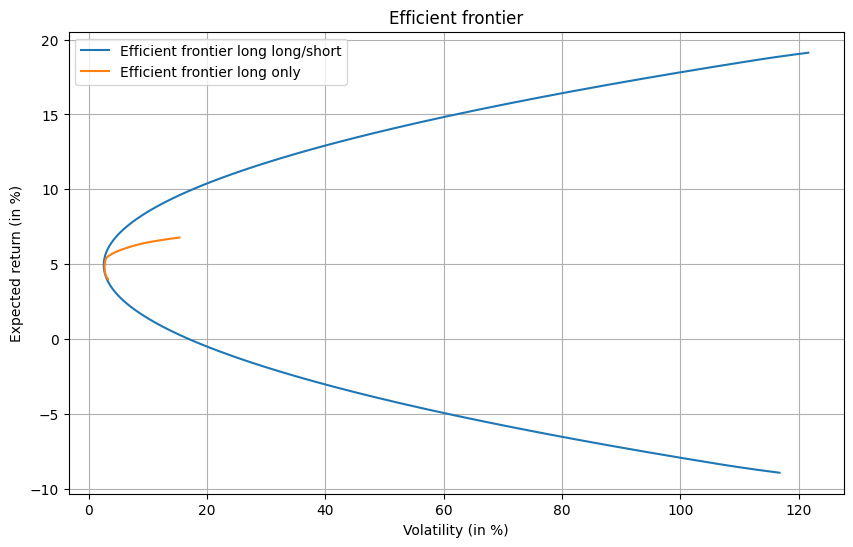

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(
    volatilities,
    returns,
    label="Efficient frontier long long/short",
)
plt.plot(
    long_volatilities,
    long_returns,
    label="Efficient frontier long only",
)
plt.legend()
plt.grid(visible=True)
plt.xlabel("Volatility (in %)")
plt.ylabel("Expected return (in %)")
plt.title("Efficient frontier")
plt.show()

### Question 3.c

In [17]:
for target in targets:
    gamma = bisection_algorithm(
        volatilities_function,
        0,
        100,
        target,
    )
    print("Gamma for target volatility of", target, ":", gamma)
    print("  Expected return:", np.dot(solve_long_only_qp_problem(gamma).T, mu) * 100)
    print("  Volatility:", volatilities_function(gamma))
    print(
        "  Sharpe ratio:",
        (np.dot(solve_qp_problem(gamma).T, mu) - r) / volatilities_function(gamma),
    )

Gamma for target volatility of 16 : 2.8191179037094116
  Expected return: 5.816924481736914
  Volatility: 16.000002130301258
  Sharpe ratio: 0.004832239329716047
Gamma for target volatility of 20 : 3.209945559501648
  Expected return: 5.916429351681867
  Volatility: 19.99998206035408
  Sharpe ratio: 0.004197520559089858


### Question 3.d

In [18]:
sharpe_ratios = (long_returns - r * 100) / long_volatilities  # Converting r into %

i = np.argmax(sharpe_ratios)
tp = solve_long_only_qp_problem(precise_gammas[i])
print("Optimal portfolio for maximum Sharpe ratio:", tp)
print("Maximum Sharpe ratio:", sharpe_ratios[i])
print("Expected return (in %):", returns[i])
print("Volatility (in %):", volatilities[i])

Optimal portfolio for maximum Sharpe ratio: [ 4.07735947e-01  2.59070320e-01  3.33193732e-01 -3.54752250e-23
 -1.12433360e-23]
Maximum Sharpe ratio: 1.1732834449458196
Expected return (in %): 5.660389275914579
Volatility (in %): 2.809495892600486


### Question 3.e

In [19]:
beta = cov_mat.dot(tp) / tp.T.dot(cov_mat).dot(tp)

for i, value in enumerate(beta):
    print("Beta for asset", i + 1, ":", value)

Beta for asset 1 : 0.9506419539705683
Beta for asset 2 : 0.9506419539705684
Beta for asset 3 : 1.098778131973197
Beta for asset 4 : 0.8433505609808085
Beta for asset 5 : 1.71113740198504


### Question 4.a-d
Theoretical questions, no code needed.
### Question 4.e

## Equity portfolio optimization with net zero objectives
### Question 1.a

In [20]:
beta = np.array(
    [0.95, 1.05, 0.45, 1.40, 1.15, 0.75, 1.00, 1.20, 1.10, 0.8, 0.7]
).reshape(-1, 1)
sigma_mat = (
    np.diag(
        [0.262, 0.329, 0.211, 0.338, 0.231, 0.259, 0.265, 0.271, 0.301, 0.274, 0.228]
    )
    ** 2
)

weights = np.array(
    [0.82, 0.123, 0.069, 0.031, 0.132, 0.126, 0.102, 0.23, 0.045, 0.028, 0.032]
)

# Computing covariance matrix
sigma_m = 0.2**2

cov_mat: np.ndarray = sigma_m * (beta.dot(beta.T)) + sigma_mat
cov_mat

array([[0.104744, 0.0399  , 0.0171  , 0.0532  , 0.0437  , 0.0285  ,
        0.038   , 0.0456  , 0.0418  , 0.0304  , 0.0266  ],
       [0.0399  , 0.152341, 0.0189  , 0.0588  , 0.0483  , 0.0315  ,
        0.042   , 0.0504  , 0.0462  , 0.0336  , 0.0294  ],
       [0.0171  , 0.0189  , 0.052621, 0.0252  , 0.0207  , 0.0135  ,
        0.018   , 0.0216  , 0.0198  , 0.0144  , 0.0126  ],
       [0.0532  , 0.0588  , 0.0252  , 0.192644, 0.0644  , 0.042   ,
        0.056   , 0.0672  , 0.0616  , 0.0448  , 0.0392  ],
       [0.0437  , 0.0483  , 0.0207  , 0.0644  , 0.106261, 0.0345  ,
        0.046   , 0.0552  , 0.0506  , 0.0368  , 0.0322  ],
       [0.0285  , 0.0315  , 0.0135  , 0.042   , 0.0345  , 0.089581,
        0.03    , 0.036   , 0.033   , 0.024   , 0.021   ],
       [0.038   , 0.042   , 0.018   , 0.056   , 0.046   , 0.03    ,
        0.110225, 0.048   , 0.044   , 0.032   , 0.028   ],
       [0.0456  , 0.0504  , 0.0216  , 0.0672  , 0.0552  , 0.036   ,
        0.048   , 0.131041, 0.0528  , 0.038

In [21]:
# Computing correlation matrix
corr_mat = np.zeros_like(cov_mat)

for i in range(len(corr_mat)):
    for j in range(i, len(corr_mat)):
        corr_mat[i, j] = cov_mat[i, j] / (np.sqrt(sigma_mat[i, i] * sigma_mat[j, j]))
        corr_mat[j, i] = corr_mat[i, j]

corr_mat

array([[1.52590175, 0.46288777, 0.30932311, 0.60074981, 0.72205149,
        0.41999469, 0.54731384, 0.64223543, 0.53003982, 0.4234691 ,
        0.44529262],
       [0.46288777, 1.40742417, 0.27225976, 0.52876747, 0.63553468,
        0.36967058, 0.48173424, 0.56528225, 0.46653001, 0.37272868,
        0.39193729],
       [0.30932311, 0.27225976, 1.18193661, 0.35334698, 0.42469379,
        0.24703105, 0.3219172 , 0.37774785, 0.31175702, 0.24907462,
        0.2619107 ],
       [0.60074981, 0.52876747, 0.35334698, 1.68625048, 0.82481621,
        0.47976971, 0.62520933, 0.73364047, 0.60547681, 0.48373861,
        0.50866812],
       [0.72205149, 0.63553468, 0.42469379, 0.82481621, 1.99136073,
        0.57664343, 0.75144981, 0.88177505, 0.72773295, 0.58141372,
        0.61137693],
       [0.41999469, 0.36967058, 0.24703105, 0.47976971, 0.57664343,
        1.33541539, 0.43709478, 0.51290088, 0.42329943, 0.33819012,
        0.35561878],
       [0.54731384, 0.48173424, 0.3219172 , 0.62520933, 0.

In [22]:
sector_volatility = np.sqrt(np.diag(cov_mat))
sector_volatility

array([0.32364178, 0.39030885, 0.22939268, 0.43891229, 0.32597699,
       0.29930085, 0.33200151, 0.36199586, 0.37282838, 0.31729482,
       0.26755186])

### Question 1.b

The volatility of the benchmark can be computed as follows:
$$ \sigma_{\text{benchmark}} = \sqrt{b^{\mathsf T} \Sigma b}$$
where $b$ is the vector of the benchmark weights.

In [23]:
b = np.array(
    [8.20, 12.30, 6.90, 3.10, 13.20, 12.60, 10.20, 23.00, 4.50, 2.80, 3.20]
)  # vector of weights of the benchmark
b = b / 100  # convert from percentage to decimal
sigma_benchmark = np.sqrt((b.T).dot(cov_mat).dot(b))
print("The volatility of the benchmark portfolio is: ", sigma_benchmark)

The volatility of the benchmark portfolio is:  0.22211447894047792


### Question 1.c

In [24]:
weighted_average = np.sum(weights * beta)
weighted_average

18.3359

Some assets have a huge ponderation where others have a smaller one.

### Question 1.d

In [25]:
implied_risk_premia: np.ndarray = (
    0.25 * cov_mat.dot(weights) / np.sqrt(weights.T.dot(cov_mat).dot(weights))
)
implied_risk_premia

array([0.07315815, 0.05127753, 0.02038272, 0.05977381, 0.05160106,
       0.03598706, 0.04549844, 0.05961668, 0.04774817, 0.03420387,
       0.029822  ])

In [26]:
r_m = 0.25 * 0.2 + 0.03

expected_returns = 0.03 + beta.T * (r_m - 0.03)
expected_returns

array([[0.0775, 0.0825, 0.0525, 0.1   , 0.0875, 0.0675, 0.08  , 0.09  ,
        0.085 , 0.07  , 0.065 ]])

### Question 1.e

In [27]:
sci12 = np.array([24, 54, 47, 434, 19, 21, 105, 23, 559, 89, 1655])

ci = np.sum(weights * sci12)
ci

144.78

In [28]:
cm12 = np.array([-2.8, -7.2, -1.8, -1.5, -8.3, -7.8, -8.5, -4.3, -7.1, -2.7, -9.9])

cm = np.sum(weights * cm12)
cm

-7.998599999999999

In [29]:
gii = np.array([0, 1.5, 0, 0.7, 0, 0, 2.4, 0.2, 0.8, 1.4, 8.4])

gi = np.sum(weights * gii)
gi

0.841

### Question 2.b

In [39]:
def solve_esg_qp_problem(t: float) -> np.ndarray:
    """Solver for the quadratic programming problem

    Args:
        t (float): t parameter

    Returns:
        np.ndarray: optimal portfolio weights
    """
    w = cp.Variable(11, "w")  # Portfolio weights

    objective = cp.Minimize(0.5 * cp.quad_form(w, cov_mat))
    constraints = [
        cp.sum(w) == 1,
        0 <= w,
        w <= 1,
        cp.sum(sci12 * w) <= 0.7 * (0.93**t) * ci,
    ]
    problem = cp.Problem(objective, constraints)

    problem.solve()

    return w.value

In [40]:
optimal_pfs12 = {}

for t in (0, 1, 2, 5, 10):

    sol = solve_esg_qp_problem(t)

    print("Optimal portfolio for t =", t, ":", sol)

    tracking_eror_volatility = np.sqrt(
        (sol - weights).T.dot(cov_mat).dot(sol - weights)
    )

    print("Tracking error volatility:", tracking_eror_volatility)

    carbon_intensity = sci12.dot(sol)

    print("Carbon intensity:", carbon_intensity)

    carbon_momentum = cm12.dot(sol)

    print("Carbon momentum:", carbon_momentum)
    green_intensity = gii.dot(sol)

    print("Green intensity:", green_intensity)

    reduction_rate = 1 - (sci12.dot(sol)) / (ci)

    print("Reduction rate:", reduction_rate)
    optimal_pfs12[t] = sol

Optimal portfolio for t = 0 : [ 9.41107406e-02  3.27897458e-02  4.44566541e-01 -1.11049960e-21
  2.05674465e-02  1.77088872e-01  6.46258951e-02  5.01546664e-21
 -9.81930926e-22  1.33855878e-01  3.23948813e-02]
Tracking error volatility: 0.3023735941373776
Carbon intensity: 101.34599999999999
Carbon momentum: -4.08325932636356
Green intensity: 0.6638019992606862
Reduction rate: 0.30000000000000004
Optimal portfolio for t = 1 : [ 9.47385283e-02  3.31210897e-02  4.45685252e-01 -8.99600982e-22
  2.13113307e-02  1.77802253e-01  6.50281881e-02  4.19223643e-21
 -8.01213843e-22  1.34325045e-01  2.79883132e-02]
Tracking error volatility: 0.3022531345536538
Carbon intensity: 94.25178
Carbon momentum: -4.062216317398387
Green intensity: 0.6289061791417362
Reduction rate: 0.349
Optimal portfolio for t = 2 : [ 9.53223708e-02  3.34292395e-02  4.46725654e-01 -7.04297226e-22
  2.20031430e-02  1.78465698e-01  6.54023207e-02  3.42947110e-21
 -6.33861046e-22  1.34761370e-01  2.38902048e-02]
Tracking erro

### Question 2.c

In [34]:
scii13 = np.array([78, 203, 392, 803, 55, 124, 283, 123, 892, 135, 1867])

ci13 = np.sum(weights * scii13)
ci13

324.57399999999996

In [35]:
cmi13 = np.array([-0.8, -1.6, -0.1, -0.2, -1.9, -2.0, -2.5, 2.1, -3.6, -0.8, -6.8])

In [36]:
def solve_esg_qp_problem13(t: float) -> np.ndarray:
    """Solver for the quadratic programming problem

    Args:
        t (float): t parameter

    Returns:
        np.ndarray: optimal portfolio weights
    """
    w = cp.Variable(11, "w")  # Portfolio weights

    objective = cp.Minimize(0.5 * cp.quad_form(w, cov_mat))
    constraints = [
        cp.sum(w) == 1,
        0 <= w,
        w <= 1,
        cp.sum(scii13 * w) <= 0.7 * (0.93**t) * ci13,
    ]
    problem = cp.Problem(objective, constraints)

    problem.solve()

    return w.value

In [37]:
optimal_pfs13 = {}

for t in (0, 1, 2, 5, 10):

    sol = solve_esg_qp_problem13(t)

    print("Optimal portfolio for t =", t, ":", sol)

    tracking_eror_volatility = np.sqrt(
        (sol - weights).T.dot(cov_mat).dot(sol - weights)
    )

    print("Tracking error volatility:", tracking_eror_volatility)

    carbon_intensity = scii13.dot(sol)

    print("Carbon intensity:", carbon_intensity)

    carbon_momentum = cmi13.dot(sol)

    print("Carbon momentum:", carbon_momentum)
    green_intensity = gii.dot(sol)

    print("Green intensity:", green_intensity)

    reduction_rate = 1 - (scii13.dot(sol)) / (ci)

    print("Reduction rate:", reduction_rate)
    optimal_pfs13[t] = sol

Optimal portfolio for t = 0 : [ 1.23623971e-01  3.01952930e-02  3.79437317e-01 -4.30095573e-20
  5.98062009e-02  1.98978490e-01  4.54811384e-02  6.52109039e-03
 -4.19747889e-20  1.55956499e-01 -2.31736933e-20]
Tracking error volatility: 0.2888612008026496
Carbon intensity: 227.20179999999993
Carbon momentum: -0.921517894492611
Green intensity: 0.37409098849180167
Reduction rate: -0.5692899571764052
Optimal portfolio for t = 1 : [ 1.39024571e-01  2.70023951e-02  3.38498510e-01 -3.94890733e-20
  8.09461876e-02  2.10068537e-01  2.91671904e-02  1.15417256e-02
 -3.85547186e-20  1.63750883e-01 -2.12913585e-20]
Tracking error volatility: 0.2818502825205457
Carbon intensity: 211.29767400000003
Carbon momentum: -0.9418892293714531
Green intensity: 0.3420644308807161
Reduction rate: -0.45943966017405735
Optimal portfolio for t = 2 : [ 1.53347129e-01  2.40330002e-02  3.00425420e-01 -3.62075595e-20
  1.00606375e-01  2.20382281e-01  1.39952188e-02  1.62109163e-02
 -3.53668759e-20  1.70999660e-01 -1

### Question 2.d

In [38]:
for key12, key13 in zip(optimal_pfs12, optimal_pfs13):
    implied_expected_return = expected_returns.dot(optimal_pfs12[key12])
    print(
        "Implied expected return for t =",
        key12,
        ":",
        np.sum(implied_expected_return - expected_returns),
    )
    implied_expected_return = expected_returns.dot(optimal_pfs13[key13])
    print(
        "Implied expected return for t =",
        key13,
        ":",
        np.sum(implied_expected_return - expected_returns),
    )

Implied expected return for t = 0 : -0.15638991353869164
Implied expected return for t = 0 : -0.13371250284171082
Implied expected return for t = 1 : -0.15609771999969324
Implied expected return for t = 1 : -0.12192577985613413
Implied expected return for t = 2 : -0.15582598000842507
Implied expected return for t = 2 : -0.11096412747954802
Implied expected return for t = 5 : -0.15511965793394084
Implied expected return for t = 5 : -0.07824256757497794
Implied expected return for t = 10 : -0.1541614068849408
Implied expected return for t = 10 : -0.03393662790006559


### Question 2.e
We expect the carbon intensity to be the same as at $t=0$ before the rebalancing, as the weights of the assets are the same when no rebalancing occurs.

### Question 3.a

In this question we have a constraint on weights where : 
$$ w_i \geq \frac{b_i}{2}$$

So in this case the QP program corresponds to: 

$$ w^* = \argmin \frac{1}{2} w^\mathsf{T} Qw - w^\mathsf{T}R$$

$$\text{s.t.} \left \{ \begin{array}{ccc} A x & = & B \\ C x & \leq & D \\ x^- & \leq & x & \leq &  x^+ \end{array} \right.$$


**where in our case** : 
- the equality constraint is the budget constraint $ \left( \sum_{i=1}^n w_i = 1  \right) $ : $ A = 1_n^\mathsf{T} $ and $ B = 1 $
- the bounds correspond to the no short-selling restriction (long-only constraint) $ \left( 0 \leq w_i \leq 1 \right) $ : $ w^- = \frac{1}{2}b_n $ and $ w^+ = 1_n $ (with $b_n$ the vector of weights of the benchmark).
- minimmization of the tracking error volatility : $ Q = \Sigma $ and $ R = 0_n $
- the decarbonization constraint : $ C = \mathcal{CI}^\mathsf{T} $ and $ D = \mathcal{CI}^⋆ $

In [ ]:
def solve_esg_qp_3_problem(t: float) -> np.ndarray:
    """Solver for the quadratic programming problem

    Args:
        t (float): t parameter

    Returns:
        np.ndarray: optimal portfolio weights
    """
    w = cp.Variable(11, "w")  # Portfolio weights

    objective = cp.Minimize(0.5 * cp.quad_form(w, cov_mat))
    constraints = [cp.sum(w) == 1, b <= w, w <= 1, ci * w <= 0.7 * (0.93**t) * ci]
    problem = cp.Problem(objective, constraints)

    problem.solve()

    return w.value

Here we just considere the time $t=0$:

In [ ]:
t = 0
sol = solve_esg_qp_3_problem(t)
print("Optimal portfolio for t =", t, ":", sol)
tracking_eror_volatility = np.sqrt((sol - weights).T.dot(cov_mat).dot(sol - weights))
print("Tracking error volatility:", tracking_eror_volatility)
carbon_momentum = cm12.dot(sol)
print("Carbon momentum:", carbon_momentum)
carbon_intensity = sci12.dot(sol)
print("Carbon intensity:", carbon_intensity)
green_intensity = gii.dot(sol)
print("Green intensity:", green_intensity)
reduction_rate = 1 - (ci * sol) / (ci)
print("Reduction rate:", reduction_rate)